# Overview
This notebook consists of two main parts:
1. Data Analysis (Development, Fatality Rate, ...) (finished)
2. Modelling and Prediction (SIR, ML approaches, ...) (not fully finished)

Note: the number of confirmed cases is strongly dependent on the number of Covid-19-tests that are performed over time. Many countries are still ramping up their testing efforts and they do so at different speeds. Thus, I will mostly exclude the number of confirmed cases from these analyses; The number of fatalities is much less error-prone, so I will focus on that instead. (I will still predict the number of confirmed cases as that's necessary for the submission file).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

In [2]:
train = pd.read_csv('../input/covid19-global-forecasting-week-2/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-2/test.csv')
submission = pd.read_csv('../input/covid19-global-forecasting-week-2/submission.csv')

In [3]:
train

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
19399,29362,NaN,Zimbabwe,2020-03-23,3.0,1.0
19400,29363,NaN,Zimbabwe,2020-03-24,3.0,1.0
19401,29364,NaN,Zimbabwe,2020-03-25,3.0,1.0
19402,29365,NaN,Zimbabwe,2020-03-26,3.0,1.0


In [4]:
train["Country_Region"] = [country_name.replace("'","") for country_name in train["Country_Region"]]

# 1. Data Analysis (Development, Fatality Rate, ...)

In [5]:
LAST_DATE = train.iloc[-1]["Date"]

## 1.1 Development

Exemplary development in one country

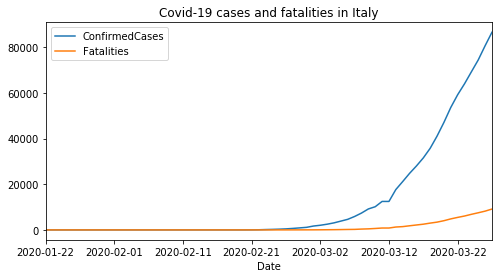

In [6]:
train[train["Country_Region"]=="Italy"][["ConfirmedCases", "Fatalities", "Date"]].plot(x="Date", figsize=(8, 4), title="Covid-19 cases and fatalities in Italy");

Progression for the whole world (i.e. all countries summed up)

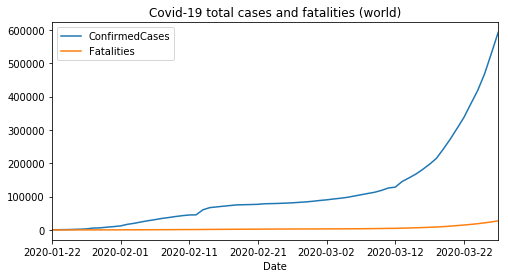

In [7]:
train.groupby("Date").sum()[["ConfirmedCases", "Fatalities"]].plot(figsize=(8, 4), title="Covid-19 total cases and fatalities (world)");

## 1.2 Fatalities and Case Fatality Rates

Countries with no fatalities yet

In [8]:
print("Countries with no fatalities as of " + LAST_DATE)
print(*train.groupby("Country_Region").sum()[train.groupby("Country_Region").sum()["Fatalities"] == 0].index.tolist(), sep=", ")

Countries with no fatalities as of 2020-03-27
Angola, Antigua and Barbuda, Bahamas, Barbados, Belarus, Belize, Benin, Bhutan, Bolivia, Brunei, Cambodia, Central African Republic, Chad, Congo (Brazzaville), Cote dIvoire, Djibouti, Dominica, El Salvador, Equatorial Guinea, Eritrea, Eswatini, Ethiopia, Fiji, Georgia, Grenada, Guinea, Guinea-Bissau, Haiti, Holy See, Kuwait, Kyrgyzstan, Laos, Latvia, Liberia, Libya, Liechtenstein, Madagascar, Maldives, Mali, Malta, Mauritania, Monaco, Mongolia, Mozambique, Namibia, Nepal, New Zealand, Oman, Papua New Guinea, Qatar, Rwanda, Saint Kitts and Nevis, Saint Lucia, Saint Vincent and the Grenadines, Senegal, Seychelles, Somalia, Sri Lanka, Suriname, Syria, Tanzania, Timor-Leste, Uganda, Uruguay, Vietnam, Zambia


Countries with the most fatalities

In [9]:
train[train["Date"] == LAST_DATE].sort_values("Fatalities", ascending=False)[["Country_Region", "ConfirmedCases", "Fatalities"]].head(10)

,Country_Region,ConfirmedCases,Fatalities
9305,Italy,86498.0,9134.0
13859,Spain,65719.0,5138.0
4157,China,67801.0,3174.0
9041,Iran,32332.0,2378.0
7787,France,32964.0,1995.0
19007,United Kingdom,14543.0,759.0
11681,Netherlands,8603.0,546.0
17027,US,44876.0,527.0
8051,Germany,50871.0,342.0
1583,Belgium,7284.0,289.0


Comparing countries' [case fatality rate](https://en.wikipedia.org/wiki/Case_fatality_rate) ("death rate"). **Careful here, Fatalities/ConfirmedCases is not necessarily the real CFR; this can only be calculated ex post**. Thus, a higher CFR as calculated *here* does not necessarily mean that one country's CFR really is higher, it could very well be because of less/more prevalent testing (example: Country A only tests patients that are already in critical condition, Country B tests the whole population -> Country A's Fatalities/ConfirmedCases - ratio will be much higher).

Only countries with at least 100 fatalities are considered.

Mean CFR (%): 2.0673159919528663


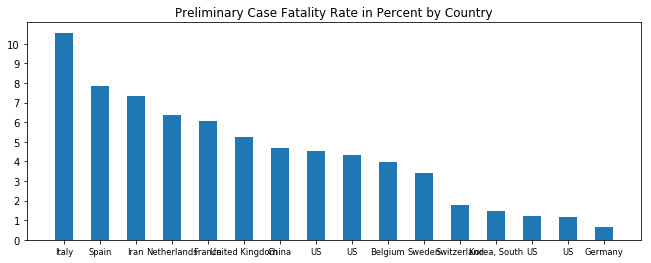

In [10]:
tmp = train[train["Date"] == LAST_DATE].copy()
tmp["CaseFatalityRate"] = tmp["Fatalities"] / tmp["ConfirmedCases"] * 100  # CFR here is Fatalities/ConfirmedCases * 100 (so that it's in percent)
print("Mean CFR (%):", tmp["CaseFatalityRate"].mean())

heights = tmp[tmp["Fatalities"] >= 100].sort_values("CaseFatalityRate", ascending=False)["CaseFatalityRate"].values
bars = tmp[tmp["Fatalities"] >= 100].sort_values("CaseFatalityRate", ascending=False)["Country_Region"].values
y_pos = np.arange(len(bars))

plt.figure(figsize=(11,4))
plt.bar(y_pos, heights, width=0.5)
 
plt.xticks(y_pos, bars, size="small")
plt.yticks(np.arange(0.0, 11.0, 1.0))
plt.title("Preliminary Case Fatality Rate in Percent by Country")

plt.show();

# 2. Modelling and Prediction

## 2.1 SIR Model

The [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) Model tries to model infectious disease developments, with the population split up into three groups ("compartments"):
- **S**usceptible: They can still be infected (healthy)
- **I**nfected: Currently infected
- **R**ecovered: They are presumed immune (cannot contract the virus again)

"$\cdot$" is "multiplied with".

Let $\beta$ (beta) be the **probability of transmission from infected to healthy $\cdot$ the number of people a person is in contact with per day**. Thus, it can be thought of as the **expected amount of people an infected person infects per day** (or any other timestep, I'll use days here). Example: Let the probability of an infected person to infect a healthy/susceptible person be $5 \%$ and the average number of people a person is in contact with per day be $6$. Then, $\beta = 0.05 \cdot 6 = 0.3$, that is, an infected person infects $0.3$ people per day on average.


Now one can see that the **number of days than an infected person can spread the disease** is extremely important. Let $D$ be that number. Then, the number of people an infected person infects on average is $=$ **expected amount of people an infected person infects per day $\cdot $ number of days the person can spread the disease**, and that's exactly $\beta \cdot D$. This is the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number) $R_{0}$. Continuing the example from above: let $D = 10$, then $R_{0} = \beta \cdot D = 0.3 \cdot 10 = 3$. That means that on average, each infected person infects $3$ others.

Now the model below does not use $D$ but $\gamma$, and that's just $= \frac{1}{D}$ (Thus, $R_{0} = \beta \cdot D = \frac{\beta}{\gamma}$ and $\beta = R_{0} \cdot \gamma$)

In [11]:
from scipy.integrate import odeint # a lot of the code for SIR from https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [12]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

We now want to add *cumulative* Deaths $X$ to the model: $X(t) = \textit{number of deaths from day 0 to day t}$ for $t\geq 13$, else $0$. 

Recursively, the number of cumulative deaths on day $t$ is equal to the number of cumulative deaths on day $t-1$ (that's $=X(t-1)$) plus the number of newly infected 13 days prior multiplied with the case fatality rate $\alpha$ (alpha) (I chose 13 days as that is reported as the average time from infection until death in [this study](https://wwwnc.cdc.gov/eid/article/26/6/20-0320_article)).

Now, the number of newly infected 13 days prior (that's the people who can die on day $t$) is equal to the number of infected 13 days prior multiplied with the expected amount of people an infected person infects per day (that's $\beta$). So the number of newly infected 13 days prior is $\beta \cdot I(t-13)$.

Putting it all together: $X(t) = X(t-1) + \alpha \cdot \beta \cdot I(t-13)$.

This is equal to the closed form formula $X(t) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{t-13} I(i)$

Proof: induction over $t$ for $t\geq 13$ (both are $0$ for $t<13$).

Base Case: $X(13) = X(12) + \alpha \cdot \beta \cdot I(13-13) = 0 + \alpha \cdot \beta \cdot I(0) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{0} I(i)$.

Assume $X(t) = X(t-1) + \alpha \cdot \beta \cdot I(t-13) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{t-13} I(i)$ holds for some $t\geq 13$. Then:

$X(t+1) = X(t+1-1) + \alpha \cdot \beta \cdot I(t+1-13) = X(t) + \alpha \cdot \beta \cdot I(t-12) \stackrel{inductive\, assumption}{=} \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{t-13} I(i) + \alpha \cdot \beta \cdot I(t-12) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{t-12} I(i) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{(t+1)-13} I(i)$

which was to be shown.


In [13]:
def SIR_model(N, D, R_0, CaseFatalityRate, max_days):
    '''
    N: total population
    D, R_0, CaseFatalityRate: see texts above
    '''
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, max_days, max_days) # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # Adding deaths (see text above)
    X = np.zeros(max_days)
    for day in range(12, max_days):
        X[day] = sum(I[:day-12])
    # X[13:] = I[:-13]
    X = alpha * X * gamma
    

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, X, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')
    ax.title.set_text('SIR-Model. Total Population: ' + str(N) + ", Days Infectious: " + str(D) + ", R_0: " + str(R_0) + ", CFR: " + str(CaseFatalityRate*100))
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Example of a SIR Model

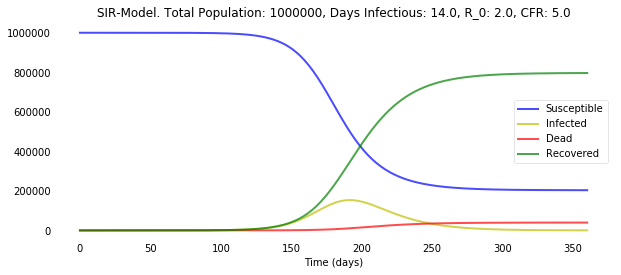

In [14]:
SIR_model(N=1_000_000, D=14.0, R_0=2.0, CaseFatalityRate=0.05, max_days=360)

## 2.2 SIR-Model with Lockdown

### We now want to find suitable parameters (Days infectious, R_0, CFR) for the SIR model

As I said before, the number of confirmed cases is likely far off from the real number (as not the whole population is getting tested) and thus is not very useful to fit our data to a SIR-Model.

So, we'll mainly use the number of deceased from the dataset to find parameters for the SIR model. What's important to note is that many countries implemented a *lockdown* that greatly reduces the basic reproduction number R_0; thus, we first tweak the model to allow for a second R_0_2 to come into effect on day L (for lockdown).

In [15]:
def SIR_model_with_lockdown(N, D, R_0, CaseFatalityRate, max_days, L, R_0_2):
    '''
    N: total population
    D, R_0, CaseFatalityRate, ...: see texts above
    '''
    # BEFORE LOCKDOWN (same code as first model)
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, L, L)  # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    
    # AFTER LOCKDOWN
    I0_2, R0_2, S0_2 = I[-1], R[-1], S[-1]  # beginning of lockdown -> starting Infected/Susceptible/Recovered numbers are the numbers at the end of no-lockdown period

    gamma = 1.0 / D  # constant
    beta_2 = R_0_2 * gamma
    alpha = CaseFatalityRate  # constant

    t_2 = np.linspace(0, max_days - L + 1, max_days - L + 1)
    
    # Initial conditions vector
    y0_2 = S0_2, I0_2, R0_2
    # Integrate the SIR equations over the time grid, t.
    ret_2 = odeint(deriv, y0_2, t_2, args=(N, beta_2, gamma))
    S_2, I_2, R_2 = ret_2.T

    
    # COMBINING PERIODS
    S_full = np.concatenate((S, S_2[1:]))
    I_full = np.concatenate((I, I_2[1:]))
    R_full = np.concatenate((R, R_2[1:]))
    t_full = np.linspace(0, max_days, max_days)
    
    # Adding deaths (see text above)
    X = np.zeros(max_days)
    for day in range(12, max_days):
        X[day] = sum(I_full[:day-12])
    # X[13:] = I[:-13]
    X = alpha * X * gamma

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t_full, S_full, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t_full, I_full, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t_full, X, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t_full, R_full, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')
    ax.title.set_text('SIR-Model with Lockdown. Total Population: ' + str(N) + 
                      ", Days Infectious: " + str(D) + ", R_0: " + str(R_0) + 
                      ", CFR: " + str(CaseFatalityRate*100) + " R_0_2: " + str(R_0_2) + 
                      ", L: " + str(L) + " days")
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    plt.text(L,N/20,'Lockdown')
    plt.plot(L, 0, marker='o', markersize=6, color="red")
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

### (fictional) Case Study: No Lockdown vs Lockdown
We model a highly infectious and deadly virus with an R_0 of 3.0 and 4 days infectious spreading in a population of 1 million. The CFR is set to 20%.
We look at the development without a lockdown and with a lockdown after 10 and 30 days that reduces R_0 to 0.9.

No Lockdown:

About 180k Fatalities at the end.

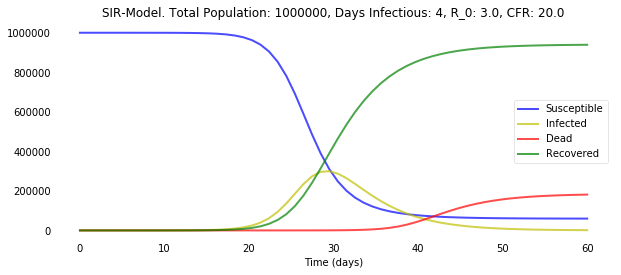

In [16]:
SIR_model(N=1_000_000, D=4, R_0=3.0, CaseFatalityRate=0.2, max_days=60)

Lockdown after 30 Days:

Fatalities around 150k. The lockdown is too late to have a significant impact. However, at the time of the lockdown, there aren't even any fatalities yet; as the R_0 is so high, the virus spreads incredibly fast and a lockdown would have to come into effect 

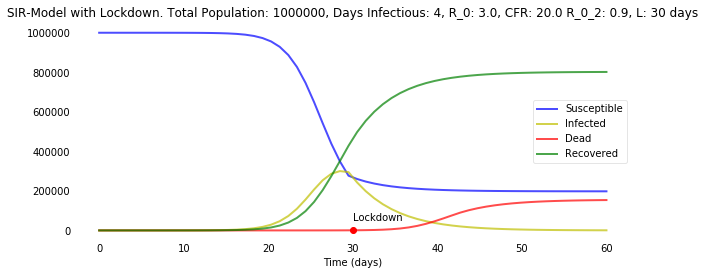

In [17]:
SIR_model_with_lockdown(N=1_000_000, D=4, R_0=3.0, CaseFatalityRate=0.2, max_days=60, L=30, R_0_2=0.9)

Lockdown after 25 days:

The lockdown is able to break the chain of infection early on! Fatalities are around 60k.

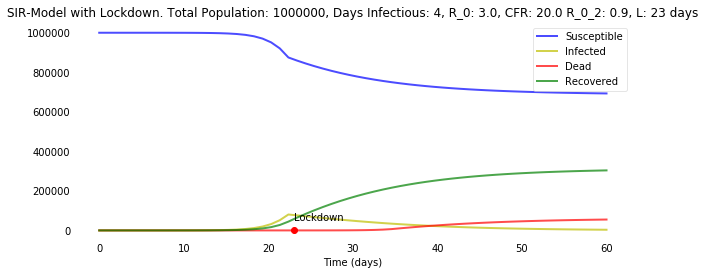

In [18]:
SIR_model_with_lockdown(N=1_000_000, D=4, R_0=3.0, CaseFatalityRate=0.2, max_days=60, L=23, R_0_2=0.9)

As you can see, with highly contagious viruses, each day counts. Let's impose even more drastic measures: a complete lockdown after 20 days that reduces R_0 to 0.1 reduces fatalities to around 8k!

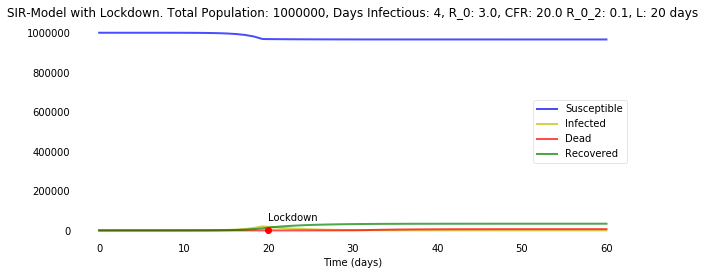

In [19]:
SIR_model_with_lockdown(N=1_000_000, D=4, R_0=3.0, CaseFatalityRate=0.2, max_days=60, L=20, R_0_2=0.1)

## 2.3 Fitting SIR with Lockdown to real-world data

We now try to fit the SIR-Model's Dead Curve to real data by tweaking the variables. Some of them are constant:
- max_days is set to `len(train.groupby("Date").sum().index)` so that we can compare against all available data
- N is fixed for each country, that's just the total population
- L is fixed for each country (the date it went into lockdown)
- D is set to vary from 5 to 20 (according to [this study](https://www.ncbi.nlm.nih.gov/pubmed/32150748), it takes on avg. 5 days to show symptoms, at most 14; according to [this source (German)](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Steckbrief.html#doc13776792bodyText5), people are infectious up to 5 days after onset of symptoms).
- CFR set to vary from $0.1\% - 10\%$ (according to [this study](https://wwwnc.cdc.gov/eid/article/26/6/20-0320_article))
- R_0 and R_0_2 are set to vary from 0.1 to 3.5

In [20]:
# SIR-Model's Fatality Curve (no plotting etc.):
def SIR_model_with_lockdown_deaths(x, N, D, R_0, CaseFatalityRate, max_days, L, R_0_2):
    # BEFORE LOCKDOWN (same code as first model)
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, L, L)  # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    
    # AFTER LOCKDOWN
    I0_2, R0_2, S0_2 = I[-1], R[-1], S[-1]  # beginning of lockdown -> starting Infected/Susceptible/Recovered numbers are the numbers at the end of no-lockdown period

    gamma = 1.0 / D  # constant
    beta_2 = R_0_2 * gamma
    alpha = CaseFatalityRate  # constant

    t_2 = np.linspace(0, max_days - L + 1, max_days - L + 1)
    
    # Initial conditions vector
    y0_2 = S0_2, I0_2, R0_2
    # Integrate the SIR equations over the time grid, t.
    ret_2 = odeint(deriv, y0_2, t_2, args=(N, beta_2, gamma))
    S_2, I_2, R_2 = ret_2.T

    
    # COMBINING PERIODS
    S_full = np.concatenate((S, S_2[1:]))
    I_full = np.concatenate((I, I_2[1:]))
    R_full = np.concatenate((R, R_2[1:]))
    t_full = np.linspace(0, max_days, max_days)
    
    # Adding deaths (see text above)
    X = np.zeros(max_days)
    for day in range(12, max_days):
        X[day] = sum(I_full[:day-12])
    # X[13:] = I[:-13]
    X = alpha * X * gamma
    return X[x]

The (hidden as it's almost the same as before) code above defines a function with signature

`SIR_model_with_lockdown_deaths(x, N, D, R_0, CaseFatalityRate, max_days, L, R_0_2)`

that takes as input the same variables as before and an x and returns the number of fatalities on day x. This function will be used to find suited parameters D, CFR, R_0 and R_0_2 for the model.

In [21]:
!pip install lmfit
from lmfit import Model

     |████████████████████████████████| 258 kB 7.1 MB/s 
     |████████████████████████████████| 52 kB 829 kB/s 
     |████████████████████████████████| 232 kB 17.9 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-py3-none-any.whl size=87914 sha256=13fba00e9ab4bef9a168df6952e7e5efe411a17b36c87e3cef4e2ae057b14165
  Stored in directory: /root/.cache/pip/wheels/e2/c7/ed/ccfe7d5de2af8a029a77c9c54f4a592381977d42da50d6be7e
  Created wheel for asteval: filename=asteval-0.9.18-py3-none-any.whl size=17382 sha256=42f376a52d2ab0caccac37fb30fa27fdbaf0d7d4b050bb159f8feb0f76bed865
  Stored in directory: /root/.cache/pip/wheels/e4/91/a3/08d0c0afc17a193dc65245d605087dc1c8b2848ec70b18d545
  Created wheel for uncertainties: filename=uncertainties-3.1.2-py3-none-any.whl size=96455 sha256=82f91c5501e6f0b009b808ffe1bea6bf81ddedb5d9db493b83e71125de68567b
  Stored in directory: /root/.cache/pip/wheels/78/52/c1/1028f3e019b7ee67e1fe1ecfaa049c464aba5fc756acbd0dd0
Successfully built lmfit asteval uncertaint

In [22]:
# Load countries data file (from https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions)
world_population = pd.read_csv("/kaggle/input/population-by-country-2020/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

We now define 
1. `fit_SIR`: this function takes a country name, lockdown data (and opt. region name) and first gathers the data (fatalities progression, population, etc.) and then fits the `SIR_model_with_lockdown_deaths`-function from above with fixed N (population), max_days (however many dates are supplied), L (lockdown date) and varying D, R_0, R_0_2, CFR. The function returns the lmfit-module's result object and the country name. The result object contains all we want to know about the curve fitting.
2. `fitted_plot`: this functino takes a lmfit-result-object and country name and plots the fitted SIR-model against the real curve.

In [23]:
def fit_SIR(country_name, lockdown_date, region_name=None):
    """
    y_data: the fatalities data of one country/region (array)
    population: total population of country
    lockdown_date: format YYYY-MM-DD
    """
    if region_name:
        y_data = train[(train["Country_Region"] == country_name) & (train["Region"] == region_name)].Fatalities.values
    else:
        if len(train["Country_Region"] == country_name) > len(train["Country_Region"] == "Germany"):  # country with several regions and no region provided
            y_data = train[(train["Country_Region"] == country_name) & (train["Region"].isnull())].Fatalities.values
        else:
            y_data = train[train["Country_Region"] == country_name].Fatalities.values
        
    max_days = len(train.groupby("Date").sum().index) # constant for all countries

    # country specific values
    N = world_population.loc[world_population['Country (or dependency)'] == country_name]["Population (2020)"].values[0]
    L = train.groupby("Date").sum().index.tolist().index(lockdown_date)  # index of the lockdown date

    # x_data is just [0, 1, ..., max_days] array
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)
    
    # curve fitting from here
    mod = Model(SIR_model_with_lockdown_deaths)

    # initial values and bounds
    mod.set_param_hint('N', value=N)
    mod.set_param_hint('max_days', value=max_days)
    mod.set_param_hint('L', value=L)
    mod.set_param_hint('D', value=10, min=2, max=25)
    mod.set_param_hint('CaseFatalityRate', value=0.01, min=0.0001, max=0.1)
    mod.set_param_hint('R_0', value=2.0, min=0.1, max=5.0)
    mod.set_param_hint('R_0_2', value=2.0, min=0.1, max=5.0)

    params = mod.make_params()

    # fixing constant parameters
    params['N'].vary = False
    params['max_days'].vary = False
    params['L'].vary = False

    result = mod.fit(y_data, params, x=x_data)
    
    return result, country_name

def fitted_plot(result, country_name, region_name=None):
    if region_name:
        y_data = train[(train["Country_Region"] == country_name) & (train["Region"] == region_name)].Fatalities.values
    else:
        if len(train["Country_Region"] == country_name) > len(train["Country_Region"] == "Germany"):  # country with several regions and no region provided
            y_data = train[(train["Country_Region"] == country_name) & (train["Region"].isnull())].Fatalities.values
        else:
            y_data = train[train["Country_Region"] == country_name].Fatalities.values

    max_days = len(train.groupby("Date").sum().index)
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)
    x_ticks = train[train["Country_Region"] == "Germany"].Date.values  # same for all countries
    
    plt.figure(figsize=(10,5))
    
    real_data, = plt.plot(x_data, y_data, 'bo', label="real data")
    SIR_fit = plt.plot(x_data, result.best_fit, 'r-', label="SIR model")
    
    plt.xlabel("Day")
    plt.xticks(x_data[::10], x_ticks[::10])
    plt.ylabel("Fatalities")
    plt.title("Real Data vs SIR-Model in " + country_name)
    plt.legend(numpoints=1, loc=2, frameon=None)
    plt.show()

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2497
    # data points      = 66
    # variables        = 4
    chi-square         = 218741.018
    reduced chi-square = 3528.08094
    Akaike info crit   = 542.995274
    Bayesian info crit = 551.753893
##  Warning: uncertainties could not be estimated:
    D:                 at boundary
    R_0_2:             at initial value
[[Variables]]
    N:                 4.675478e+07 (fixed)
    D:                 2.00000003 (init = 10)
    R_0:               1.44953252 (init = 2)
    CaseFatalityRate:  0.01504491 (init = 0.01)
    max_days:          66 (fixed)
    L:                 53 (fixed)
    R_0_2:             2.00000000 (init = 2)


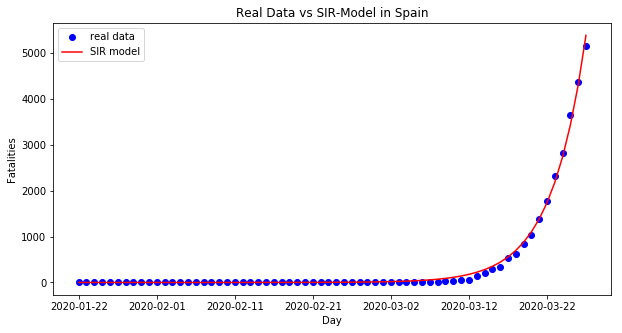

In [24]:
result, _ = fit_SIR("Spain", "2020-03-15")
print(result.fit_report())
fitted_plot(result, "Spain")

# //TODO: 
1. use fitted SIR-Models to predict for all countries
2. use ML to predict